# Práctica 03. Análisis Estadistico de señales

### Estudiante: Camila Segura
### Identificación: 1000795135

 Funciones en Python:

*   mean: Calcula el promedio de un conjunto de datos (np.mean())
*   var: Calcula la varianza de un conjunto de datos, es decir mide cuánto se dispersan los datos respecto a la media.
*   std: Calcula la desviación estandar (raiz cuadrada de la varianza) y arroja valores más faciles de interpretar que la varianza

In [135]:
!pip install pandas

In [136]:
#Exportar los datos
!pip install scipy #isntalar la libreria scipy que permitirá leer los archivos .mat


In [137]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks #ayudará más adelnate a buscar picos de señales
import pandas as pd
from scipy.stats import shapiro #Prueba de Shapiro
from scipy.stats import levene #Prueba de homocedasticidad
from scipy.stats import mannwhitneyu #Prueba de Mann Whitney U
from statsmodels.tsa.stattools import adfuller #Prueba de Augmented Dickey-Fuller

## Exportar los datos de interes para ECG

In [138]:
# Cargar archivo .mat
mat = sio.loadmat("signals.mat")

# Ver qué variables contiene para saber cuales exportar
print(mat.keys())

#verificar el tamaño del arreglo
raw = mat['ECG_asRecording']
print(raw.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])
(1, 30720)


Se hará uso de la funcion np.squeeze ya que esta permite pasar de un vector 2D, como se observa en el tamaño del vector ECG_asRecording, a un arreglo plano de una dimensión. Esto es importante para realizar operaciones matemáticas a lo largo del informe.

In [139]:
#Extaer cada una de las variables a usar para análisis ECG
fs = float(np.squeeze(mat['Fs'])) # frecuencia de muestreo
original_ECG = np.squeeze(mat['ECG_asRecording'])  # señal original sin ninun tipo de proceso
filtrada_ECG = np.squeeze(mat['ECG_filtered'])    # señal filtrada

print("Frecuencia de muestreo:", fs, "Hz")
print("Tamaño ECG cruda:", original_ECG.shape)
print("Tamaño ECG filtrada:", filtrada_ECG.shape)

Frecuencia de muestreo: 1024.0 Hz
Tamaño ECG cruda: (30720,)
Tamaño ECG filtrada: (30720,)


Ya teniendo un tamaño de (30720,) es más fácil continuar con las operaciones a lo largo del taller

## Creación de la funcion RMS

In [140]:
#funcion de RMS
def rms(x):
    x = np.asarray(x, dtype=float)   # asarray --> devuelve la información en un arreglo numpy
    return np.sqrt(np.mean(x**2))

## Tiempo de duración de las señales

In [141]:
muestras_original = len(original_ECG) #muestras del vector original
muestras_filtrada = len(filtrada_ECG) #muestras del vector filtrado

#calcular el tiempo
tiempo_original = muestras_original/fs # T = N(1/fs)
print(tiempo_original)
tiempo_filtrado = muestras_filtrada/fs
print(tiempo_filtrado)

#creacion vector tiempo
tiempo = np.arange(muestras_filtrada)/fs #convertir a un arreglo numpy
print(tiempo)


30.0
30.0
[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 2.99970703e+01
 2.99980469e+01 2.99990234e+01]


## Comparativa entre señal filtrada y sin filtrar

Se realiza un recorte en la señal para visualizar solo el comportamiento de las señales en los dos primeros segundos.

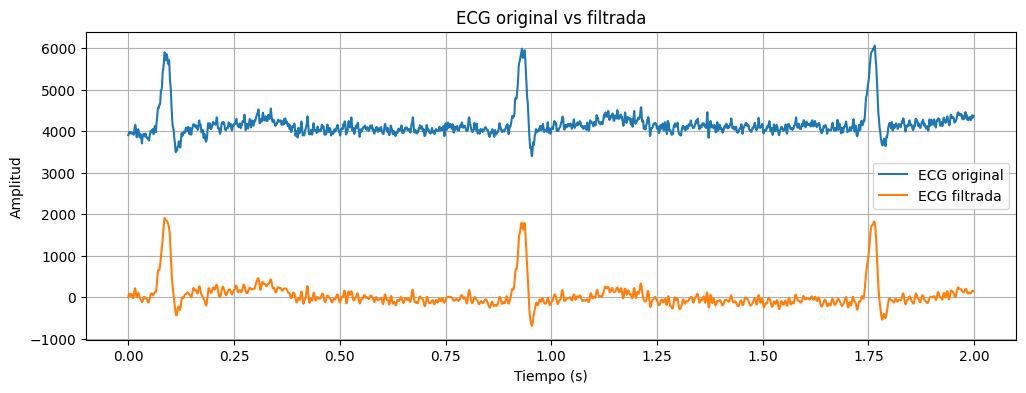

In [142]:
#para ver los datos los primeros 2 segundos
muestras_2s = int(2*fs) #permite ver las muestras de los 2 primeros segundos

#Cortar cada uno de los vectores de interes para visualizar solo las muestras de 2 segundos
tiempo_2 = tiempo[:muestras_2s]
original_ECG2 = original_ECG[:muestras_2s]
filtrada_ECG2 = filtrada_ECG[:muestras_2s]

plt.figure(figsize=(12,4))
plt.plot(tiempo_2, original_ECG2, label="ECG original")
plt.plot(tiempo_2, filtrada_ECG2, label="ECG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG original vs filtrada")
plt.grid()
plt.legend()
plt.show()

La señal original muestra claramente los complejos QRS, con picos pronunciados que corresponden a los latidos cardíacos. La amplitud de estos picos varía alrededor de 4000–6000 unidades, mientras que la señal filtrada se centra alrededor de cero, eliminando el nivel de la linea de referencia que está presente en la señal original. Esto ocurre porque el filtro aplicado atenúa las componentes de muy baja frecuencia, responsable del desplazamiento de la línea base. Esto indica que el filtro aplicado actúa principalmente atenuando ruido de alta frecuencia y componentes de bajo interés como lo son los ruidos musculares o de la red electrica, con el objetivo de mantener los rangos de frecuencias características del ECG, típicamente entre 0.5 y 40 Hz para las señales clínicas [1]. La forma de la señal filtrada sigue mostrando todos los picos QRS, permitiendo contar los latidos, en el intervalo de 2 segundos se observan 3 picos, lo que es consistente con una frecuencia cardíaca normal. Esto significa que en un análisis de mayor duración, por ejemplo 1 minuto, se podría estimar una frecuencia aproximada de 90 latidos por minuto [1].

## Obtener un ciclo cardiaco de la señal original y la filtrada.

/tmp/ipython-input-898345844.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


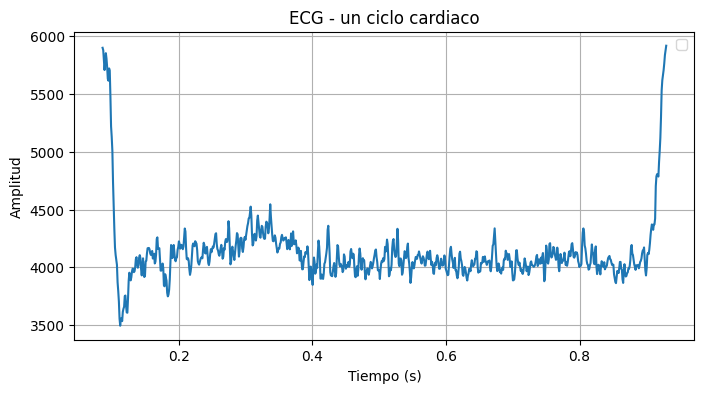

In [143]:
#Para la señal original
peaks, _ = find_peaks(original_ECG, distance=int(0.6*fs)) #se establece una distancia para que no se grafiquen solo 2 puntos

picos_señal = original_ECG[peaks[0]:peaks[1]]
tiempo_picos = tiempo[peaks[0]:peaks[1]]

plt.figure(figsize=(8,4))
plt.plot(tiempo_picos, picos_señal)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG - un ciclo cardiaco")
plt.legend()
plt.grid(True)
plt.show()

In [144]:
#medidas de tendencia de la señal original
media = np.mean(picos_señal)
varianza = np.var(picos_señal)
desviacion_estandar = np.std(picos_señal)
RMS = rms(picos_señal)

print("El promedio del ciclo cardiaco corresponde a ser: ", media)
print("La varianza del ciclo cardiaco corresponde a ser: ", varianza)
print("La desviación estandar del ciclo cardiaco corresponde a ser: ", desviacion_estandar)
print("El error medio cuadrático del ciclo corresponde a ser: ", RMS)

El promedio del ciclo cardiaco corresponde a ser:  4131.136266878161
La varianza del ciclo cardiaco corresponde a ser:  93646.2220564969
La desviación estandar del ciclo cardiaco corresponde a ser:  306.01670225086883
El error medio cuadrático del ciclo corresponde a ser:  4142.454957820607


/tmp/ipython-input-1163897571.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


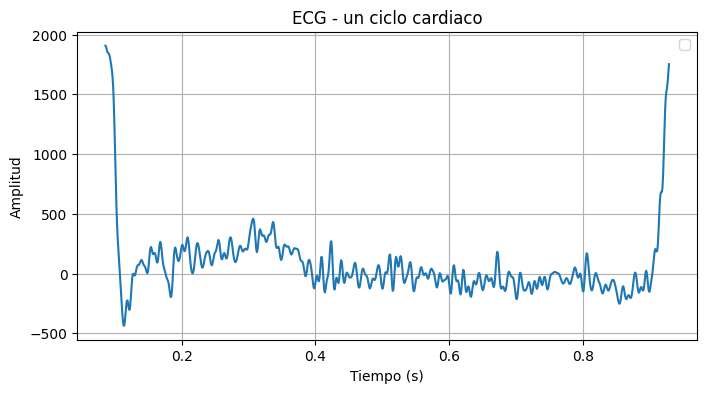

In [145]:
#Para la señal filtrada
peaks, _ = find_peaks(filtrada_ECG, distance=int(0.6*fs)) #se establece una distancia para que no se grafiquen solo 2 puntos

picos_señal_f = filtrada_ECG[peaks[0]:peaks[1]]
tiempo_picos = tiempo[peaks[0]:peaks[1]]

plt.figure(figsize=(8,4))
plt.plot(tiempo_picos, picos_señal_f)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG - un ciclo cardiaco")
plt.legend()
plt.grid(True)
plt.show()

In [146]:
#medidas de tendencia de la señal filtrada
media_f = np.mean(picos_señal_f)
varianza_f = np.var(picos_señal_f)
desviacion_estandar_f = np.std(picos_señal_f)
RMS_f = rms(picos_señal_f)

print("El promedio del ciclo cardiaco corresponde a ser: ", media_f)
print("La varianza del ciclo cardiaco corresponde a ser: ", varianza_f)
print("La desviación estandar del ciclo cardiaco corresponde a ser: ", desviacion_estandar_f)
print("El error medio cuadrático del ciclo corresponde a ser: ", RMS_f)

El promedio del ciclo cardiaco corresponde a ser:  74.00995782055861
La varianza del ciclo cardiaco corresponde a ser:  96684.31488232457
La desviación estandar del ciclo cardiaco corresponde a ser:  310.94101511753735
El error medio cuadrático del ciclo corresponde a ser:  319.62757818893766


En la señal original, el promedio del ciclo cardíaco se encuentra alrededor de 4131, mientras que en la señal filtrada este valor cae drásticamente a aproximadamente 74. Esta diferencia refleja directamente el efecto del filtro, ya que al eliminar la componente de muy baja frecuencia y el desplazamiento de la línea base, la señal se centra alrededor de cero.

La varianza en ambos casos es similar, con valores cercanos a 93,646 en la señal original y 96,684 en la señal filtrada. Esto indica que la dispersión de los valores respecto a su media no sufren cambios significativos, lo que confirma que el filtrado no reduce la variabilidad propia del ciclo cardíaco.

En cuanto a la desviación estándar, los resultados son muy cercanos (306 en la señal original y 311 en la filtrada), lo cual refuerza la idea de que la amplitud relativa de los complejos QRS y la variabilidad de la señal no se ven comprometidas tras el filtrado.

Finalmente, el error medio cuadrático muestra un contraste importante: en la señal original tiene un valor cercano a 4142, mientras que en la señal filtrada se reduce a 320. Esta disminución se explica porque, al remover el offset y centrar la señal alrededor de cero, la magnitud media de la señal respecto al eje de referencia se hace mucho menor.

Por medio de esta verificación estadistica se puede corroborar que el filtrado no altera la composición de la señal del ECG, como lo es los valores pico a pico de la señal, el componente QRS, entre otros, lo que útil para análisis médicos.

## Análisis 15 ciclos de la señal filtrada con sus medidad de tendencia.

Para el analisis de los ciclos cardiacos se hizo uso de la funcion find_peaks el cual detecta los máximos locales de una señal, en este caso el argumento de distance permite indicarle al algortimo esa separación máxima que existe entre picos expresada en número de muestras teniendo en cuenta la frecuencia de muestreo. Se hizo uso de 0.6 segundos para establecer los latidos por minutos de un sujeto sano (60/0.6) es decir en 60s segundo cuando latidos existiran en un intervalo de 0,6 segundos. Esto se hace con el objetivo de poder establecer picos cardiacos R de diferentes ciclos cardiacos y que el algoritmo no detecte dos picos seguidos en un rango de condiciones normales [1].

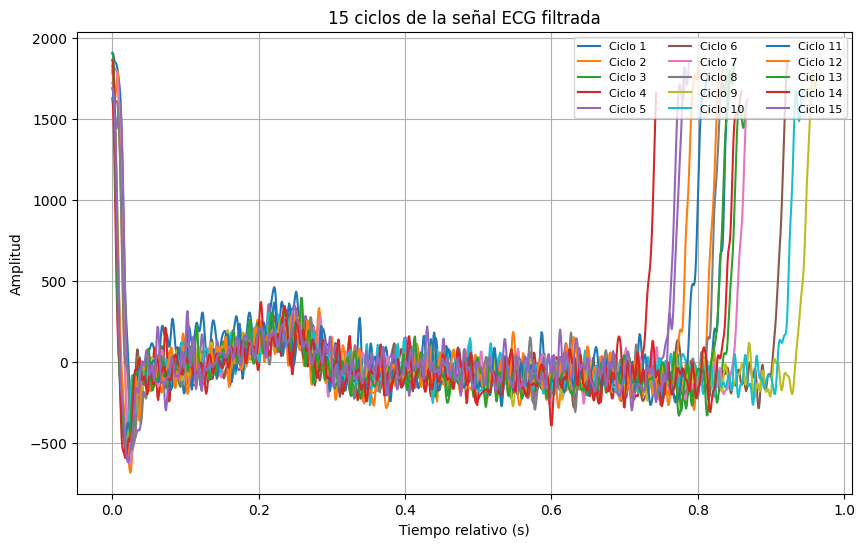

In [157]:
# Detectar picos R en la señal filtrada
peaks, _ = find_peaks(filtrada_ECG, distance=int(0.6*fs))  # separación mínima 0.6s

# Extraer 15 ciclos
num_ciclos = 15
ciclos = []  # se guardarán los valores de cada ciclo
medias, varianzas, desviacion, RMS = [], [], [], []

for i in range(num_ciclos):
    ciclo = filtrada_ECG[peaks[i]:peaks[i+1]]
    ciclos.append(ciclo)
    medias.append(np.mean(ciclo))
    varianzas.append(np.var(ciclo))
    desviacion.append(np.std(ciclo))
    RMS.append(rms(ciclo))

# Graficar todos los ciclos superpuestos
plt.figure(figsize=(10,6))

for i, ciclo in enumerate(ciclos):
    # Generar un eje de tiempo relativo para cada ciclo
    t_ciclo = np.linspace(0, len(ciclo)/fs, len(ciclo))
    plt.plot(t_ciclo, ciclo, label=f"Ciclo {i+1}")

plt.xlabel("Tiempo relativo (s)")
plt.ylabel("Amplitud")
plt.title("15 ciclos de la señal ECG filtrada")
plt.legend(loc="upper right", fontsize=8, ncol=3)
plt.grid(True)
plt.show()



In [148]:
#Crear tabla con los resultados para que se vean ordenados
tabla = pd.DataFrame({
    "Ciclo": range(1, 16),
    "Media": medias,
    "Varianza": varianzas,
    "Desv.Std": desviacion,
    "RMS": RMS
})
tabla = tabla.round(1) #Se redondea a solo 1 decimal para que no quede tan largo

print(tabla)


    Ciclo  Media  Varianza  Desv.Std    RMS
0       1   74.0   96684.3     310.9  319.6
1       2   -1.5  104790.5     323.7  323.7
2       3  -10.4   82451.3     287.1  287.3
3       4  -21.0   46839.0     216.4  217.4
4       5   40.9  114850.0     338.9  341.4
5       6  -27.9   58147.6     241.1  242.8
6       7    0.4   77707.3     278.8  278.8
7       8   21.4  100268.2     316.7  317.4
8       9  -10.2   71785.0     267.9  268.1
9      10    8.8   68481.1     261.7  261.8
10     11   -8.9   76088.4     275.8  276.0
11     12   13.2   93862.7     306.4  306.7
12     13   -4.2   87951.5     296.6  296.6
13     14  -15.0   77022.1     277.5  277.9
14     15   27.1   89636.9     299.4  300.6


Para un electrocardiograma, se dice que la señal es estacionaria cuando no se evidencian variaciones significativas en su amplitud a lo largo de los ciclos cardiacos, es decir que existe un comportamiento regular y constante muy relacionado con la salud del paciente y el funcionamiento saludable del corazón [2]. Esto se puede analizar desde la perspectiva estadística en donde:

Media: se puede observar que existe una variación entre -27 y +74, lo que permite ver que el filtro sí se alineó alrededor de cero, pero no se cumple una alineación en cuanto a las señales, unas son negativas y otras positivas.

Varianza: se mantiene en un rango de 46.000 y 114.000, lo que permite ver que no existen cambios tan abruptos en la variabilidad de los ciclos, pero si se puede decir que hay cambios entre ciclos cardiacos.

Desviación estándar: esta medida permite establecer la amplitud de cada uno de los ciclos, como se puede observar en la tabla no tiene variaciones tan grandes, lo que permite entender que la amplitud de la señal se mantiene de cierta forma constante y regular.

RMS: al igual que la desviación, no presenta cambios extremos, lo que permite deducir que la magnitud de las señales es similar a lo largo de su eje de referencia.

Con esta información se puede corroborar la idea de que una señal de ECG para un sujeto sano corresponde a ser estacionaria. El promedio tiene ciertas fluctuaciones, pero siempre son valores cercanos a 0 aunque existan ciertos picos lejanos como 74; asimismo, la varianza y la desviación se mantienen muy constantes y no se ven cambios drásticos.

La gráfica de los 15 ciclos de la señal ECG filtrada superpuestos permite analizar de manera clara la estacionaridad de la señal. Al estar alineados en el pico R, se observa que la forma de onda (ondas P, complejo QRS y onda T) se mantiene muy parecida en todos los ciclos, lo cual es un indicio de comportamiento estable y repetitivo. En cuanto a la amplitud, no se presentan diferencias significativas en la altura de los complejos QRS ni de las ondas T, mostrando que la energía de la señal se conserva de un ciclo a otro. Del mismo modo, el tiempo relativo entre ciclos se mantiene constante, sin compresiones ni dilataciones abruptas

## Comparación entre ciclos usando pruebas estdisticas
Se van a seleccionar ciclos que esten alejados entre ellos para asi evaluar el compotamiento de ciclos no contiguos.

In [149]:
#Se eligen dos ciclos para las pruebas
ciclo_1 = ciclos[3] #ciclo 4
print(ciclo_1.shape)
ciclo_2 = ciclos[4] #ciclo 13

(761,)


La prueba t de Student es una prueba estadística que analiza si dos muestras proceden de poblaciones que cuentan con la misma media. Cuantifica la diferencia entre la media de las dos muestras y, teniendo en cuenta su varianza, estima la probabilidad de que se obtenga una diferencia igual o mayor a la que se observa si se establece que la hipótesis nula establece que las medias poblacionales son iguales. Esa probabilidad se conoce como p-value. Cuando se habla de p-value se tiene que definir un rango en donde se establece si se rechaza o no la hipótesis nula. Cuando p-value es mayor que cierto límite determinado, se dice que no se rechaza la hipótesis nula; si ese valor es menor, se considera que la hipótesis nula se rechaza [3].

***Hipótesis nula***: No hay diferencias entre los ciclos elegidos, es decir que las medidas poblacionales son iguales.

***Hipótesis alternativa***: Sí existe una diferencia entre las medidas de los ciclos.

Las condiciones de un t de Student son:

- Independencia: Observaciones independientes entre ellas.

- Normalidad: Las muestras se tienen que distribuir de forma normal.

- Igualdad de varianza (homocedasticidad): La varianza de ambas poblaciones debe ser igual.

Se va a asumir un valor para establecer la estadística del problema:

- p > 0.05: las varianzas son iguales y se asume normalidad.

- p <= 0.05: las varianzas son diferentes y los datos no son normales.

In [150]:
from scipy.stats import shapiro

#Para l prueba de normalidad
prueba1, p_1 = shapiro(ciclo_1)
prueba2, p_2 = shapiro(ciclo_2)

print(f"Ciclo 1 p-valor normalidad: {p_1}")
print(f"Ciclo 2 p-valor normalidad: {p_2}")

Ciclo 1 p-valor normalidad: 2.5586738564091682e-36
Ciclo 2 p-valor normalidad: 1.6230300122465056e-40


Cuando se habla de la prueba de normalidad para determinar si aplicar la t de student, se obtuvieron p-valores extremadamente bajos (2.55e-36 y 1.62e-40, respectivamente), muy inferiores al umbral de 0.05 que se estableció anteriormente, por lo que se rechaza la hipótesis nula de normalidad y se concluye que esos ciclos no siguen una distribución normal. Se utilizó la prueba de Shapiro–Wilk porque está especialmente recomendada para muestras pequeñas [3], como los ciclos individuales de un ECG. Este tipo de prueba tiene buena potencia estadística y es sensible a desviaciones de la normalidad, lo que la hace adecuada para establecer el uso de la ecuacion t de student.


In [151]:
from scipy.stats import levene

prueba_varianza, p_1_v = levene(ciclo_1, ciclo_2)
print(f"Prueba de Levene p-valor: {p_1_v}")

Prueba de Levene p-valor: 0.0004643053549308521


La prueba de Levene arrojó un p-valor de 0.000464, el cual es mucho menor que el umbral de 0.05. Esto implica que se debe rechazar la hipótesis nula de igualdad de varianzas, concluyendo que los ciclos analizados no presentan homocedasticidad, sino que sus varianzas son significativamente diferentes. Este tipo de prueba se realiza con el objetivo de analizar si la dispersión de los valores en torno a la media es similar en los ciclos comparados [3]. Este resultado confirma que tampoco se cumple otra de las condiciones necesarias para aplicar una prueba t de Student.

In [152]:
from scipy.stats import mannwhitneyu

prueba_u, p_u = mannwhitneyu(ciclo_1, ciclo_2)
print(f"Prueba Mann-Whitney p-valor: {p_u}")

Prueba Mann-Whitney p-valor: 8.421413997601233e-05


Dado que no se cumplieron las condiciones necesarias para aplicar una prueba t de Student , pues la prueba de Shapiro-Wilk mostró que los ciclos no siguen una distribución normal y la prueba de Levene indicó que sus varianzas son desiguales, se recurrió a una prueba no paramétrica, en este caso la prueba de Mann-Whitney. El resultado arrojó un p-valor de 8.42e-5, claramente menor al umbral de 0.05, lo que implica rechazar la hipótesis nula de igualdad entre las distribuciones de los ciclos analizados. Por lo tanto, se concluye que existe una diferencia estadísticamente significativa entre ellos, confirmando que no se comportan de manera equivalente y presentan variaciones importantes en sus características estadísticas.


Al rechazarse todas las pruebas realizadas se procede hacer la prueba de Dickey - Fuller.

## Prueba de Dickey - Fuller para establecer estacionariedad.

In [153]:
señal = np.concatenate([ciclo_1, ciclo_2])

In [154]:
from statsmodels.tsa.stattools import adfuller

# Realizamos la prueba ADF para los dos ciclos analizados anteriormente
resultado = adfuller(señal)

print("ADF Statistic:", resultado[0])
print("p-valor:", resultado[1])
print("Valores críticos:", resultado[4])

ADF Statistic: -2.941408314952026
p-valor: 0.04074033419280568
Valores críticos: {'1%': np.float64(-3.4345923608042512), '5%': np.float64(-2.8634137428910185), '10%': np.float64(-2.567767551360439)}


La prueba ADF entregó un estadístico de -2.94 con un p-valor de 0.0407. Como el p-valor es menor a 0.05, se rechaza la hipótesis nula de que la señal tenga raíz unitaria, lo que indica que la serie puede considerarse estacionaria. Al mirar los valores críticos, se ve que el estadístico es menor que el valor al 5% (-2.86), pero no alcanza el valor crítico más estricto del 1% (-3.43). Por lo tanto, se concluye que hay evidencia de estacionariedad, aunque no de forma muy fuerte, sino suficiente para trabajar al nivel de significancia del 5%, lo preferible es que el valor del 1% sea el mejor. Esto tambien se puede dar por el comportamiento de los ciclos en la grafica.

In [155]:
# Realizamos la prueba ADF para los 15 ciclos
señal_total = np.concatenate(ciclos)
resultado = adfuller(señal_total)

print("ADF Statistic:", resultado[0])
print("p-valor:", resultado[1])
print("Valores críticos:", resultado[4])

ADF Statistic: -7.297961550231237
p-valor: 1.3621567413809937e-10
Valores críticos: {'1%': np.float64(-3.4308529676486708), '5%': np.float64(-2.8617622874368585), '10%': np.float64(-2.566888318671982)}


Al igual que el analisis anterior, este permite visualizar el comportamiento de los 15 ciclos, por ende se puede determinar que toda la señal con 15 ciclos cardiacos cuenta con una tendencia estacionaria.

## Conclusiones:

- El preprocesamiento mediante filtrado pasa-banda permitió eliminar la línea base y el ruido de alta frecuencia, conservando las componentes principales del ECG, en particular los complejos QRS, lo que facilita el análisis de los ciclos cardiacos sin afectar la información clínica esencial. Esto se determinó tanto de manera gráfica como estadistica, por ende hacer el analisis adicional con media, varianza, desviacion y RMS permite un analisis más completo respecto a la seña.

- Los parámetros estadísticos (media, varianza, desviación estándar y RMS) mostraron estabilidad entre ciclos, lo que sugiere un comportamiento estacionario de la señal. Las pruebas de Shapiro-Wilk y Levene confirmaron que no se cumplían las condiciones para aplicar una prueba t de Student, por lo que se recurrió a pruebas no paramétricas como Mann-Whitney, que evidenciaron diferencias significativas entre algunos ciclos.

- La prueba Dickey-Fuller aumentada aplicada a un solo ciclo mostró estacionariedad moderada, pero al extender el análisis a 15 ciclos el estadístico fue ampliamente significativo, confirmando con alta confianza que la señal global puede considerarse estacionaria, lo esperado para un análisis de un sujeto sano.

## Referencias

[1] Matematizame, “La desviación estándar en estadística: impacto y calidad de análisis”, Matematizame. [En línea]. Disponible: https://matematizame.com/la-desviacion-estandar-en-estadistica-impacto-y-calidad-de-analisis/?damemas_lectura=1

[2] J. Amat Rodrigo, “T-test con Python”, CienciaDeDatos.net, Dic. 2021. [En línea]. Disponible: https://cienciadedatos.net/documentos/pystats10-t-test-python.html

[3] J. Amat Rodrigo, “T-test con Python”, CienciaDeDatos.net, Dic. 2021. [En línea]. Disponible: https://cienciadedatos.net/documentos/pystats10-t-test-python.html
